In [1]:
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd

In [2]:
d1 = 183.3 #joint 1 height [mm]
d2 = 737.31 #joint 2 radius [mm]
d3 = 387.8 #joint 3 radius [mm]
d4 = 95.5 #joint 4 radius [mm]
d5 = 115.5 #joint 5 radius [mm]
d6 = 76.8 #end effector offset
q = sp.pi/2 #standard 90 degree angle



In [3]:
#Initialize symbols
thetai = sp.Symbol('theta_i')

t = sp.Symbol('t')
ai = sp.Symbol('a_i')
di = sp.Symbol('d_i')
alphai = sp.Symbol('alpha_i')
pi = sp.Symbol('pi')

In [4]:
thetas = sp.symbols('theta_1:7')
dh_theta = [thetas[0], thetas[1]+q, thetas[2], thetas[3]+q, thetas[4], thetas[5]]
dh_a = [0, d2, d3, 0, 0, 0]
dh_d = [d1, 0, 0, d4, d5, d6]
dh_alpha = [q, 0, 0, q, -q, 0]

In [5]:
#Create dh table based on chosen coordinate frames

dh_table = {
    "": ["to 1", "to 2", "to 3", "to 4", "to 5", "to 6"],
    thetai: [dh_theta[0],dh_theta[1],dh_theta[2],dh_theta[3],dh_theta[4],dh_theta[5]],
    ai: [dh_a[0],dh_a[1],dh_a[2],dh_a[3],dh_a[4],dh_a[5]],
    di: [dh_d[0],dh_d[1],dh_d[2],dh_d[3],dh_d[4],dh_d[5]],
    alphai: [dh_alpha[0],dh_alpha[1],dh_alpha[2],dh_alpha[3],dh_alpha[4],dh_alpha[5]]

}

df = pd.DataFrame(dh_table)
df

,,theta_i,a_i,d_i,alpha_i
0,to 1,theta_1,0.00,183.3,pi/2
1,to 2,theta_2 + pi/2,737.31,0.0,0
2,to 3,theta_3,387.80,0.0,0
3,to 4,theta_4 + pi/2,0.00,95.5,pi/2
4,to 5,theta_5,0.00,115.5,-pi/2
5,to 6,theta_6,0.00,76.8,0


In [6]:
A_array = [sp.zeros(4,4)]*6
for i in range(0,6):
    A_array[i] = sp.Matrix([
        [sp.cos(dh_theta[i]),-sp.sin(dh_theta[i])*sp.cos(dh_alpha[i]),sp.sin(dh_theta[i])*sp.sin(dh_alpha[i]),dh_a[i]*sp.cos(dh_theta[i])],
        [sp.sin(dh_theta[i]),sp.cos(dh_theta[i])*sp.cos(dh_alpha[i]),-sp.cos(dh_theta[i])*sp.sin(dh_alpha[i]),dh_a[i]*sp.sin(dh_theta[i])],
        [0,sp.sin(dh_alpha[i]),sp.cos(dh_alpha[i]),dh_d[i]],
        [0,0,0,1]
    ])

A_final = A_array[0]
for i in range(1,6):
    A_final = A_final*A_array[i]

A_products = [A_array[0]]*6
for i in range(1,6):
    A_products[i] = A_products[i-1]*A_array[i]



In [7]:
def subs_function(matrix,sub_values):
    result = matrix.subs([
        (thetas[0],sub_values[0]),
        (thetas[1],sub_values[1]),
        (thetas[2],sub_values[2]),
        (thetas[3],sub_values[3]),
        (thetas[4],sub_values[4]),
        (thetas[5],sub_values[5])     
    ])
    return result

def subs_position_vector(matrix,sub_values):
    msubs = matrix.subs([
        (thetas[0],sub_values[0]),
        (thetas[1],sub_values[1]),
        (thetas[2],sub_values[2]),
        (thetas[3],sub_values[3]),
        (thetas[4],sub_values[4]),
        (thetas[5],sub_values[5])   
    ])
    result = sp.Matrix([
        [msubs[0,3]],
        [msubs[1,3]],
        [msubs[2,3]],
        [0],
        [0],
        [0]
    ])
    return result


In [8]:


#Validate transformation matrix:

val_matrix = sp.Matrix([
    [0, q, 0, 0, 0],
    [0, 0, q, 0, 0],
    [0, 0, 0, q, 0],
    [0, 0, 0, 0, q],
    [0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0]
])

A_vals = [sp.zeros(4,4)]*5
for i in range(0,5):
    A_vals[i] = subs_function(A_final,val_matrix[:,i])


pos_vals = ["start position","first joint rotated 90 degrees","shoulder rotated 90 degrees","elbow rotated 90 degrees","wrist rotated 90 degrees"]
print("Transformation matrix validation")
for i in range(0,5):
    print("---------------")
    print(pos_vals[i])
    print(
        "x = ",((A_vals[i])[0,3]).round(2),
        "y = ",((A_vals[i])[1,3]).round(2),
        "z = ",((A_vals[i])[2,3]).round(2))




Transformation matrix validation
---------------
start position
x =  0 y =  -172.30 z =  1423.91
---------------
first joint rotated 90 degrees
x =  172.30 y =  0 z =  1423.91
---------------
shoulder rotated 90 degrees
x =  -1240.61 y =  -172.30 z =  183.30
---------------
elbow rotated 90 degrees
x =  -503.30 y =  -172.30 z =  920.61
---------------
wrist rotated 90 degrees
x =  -115.50 y =  -172.30 z =  1308.41


In [9]:
thetas_vector = sp.Matrix([thetas[0],thetas[1],thetas[2],thetas[3],thetas[4],thetas[5]])

P = sp.Matrix([A_final[0,3],A_final[1,3],A_final[2,3]])

Jv = P.jacobian(thetas_vector)
Z = sp.zeros(3,6)

for c in range(0,6):
    for r in range(0,3):
        Z[r,c] = (A_products[c])[r,2]


J = sp.zeros(6,6)
for c in range(0,6):
    for r in range(0,3):
        J[r,c] = Jv[r,c]
        J[r+3,c] = Z[r,c]




In [10]:
#initialize inputs
increment = 1 #time increment [s]
duration = 200 #total time [s]
arraysize = int(duration/increment) 
time = np.arange(0, duration, increment) #time array

theta_initial = sp.Matrix([0.01,3.14/6,-3.14/3,3.14/6,0.02,0.03])
ee_A_final = subs_position_vector(A_final,theta_initial)

#initial end effector posiitons with respect to base frame [mm]
ee_x_initial = ee_A_final[0] 
ee_y_initial = ee_A_final[1]
ee_z_initial = ee_A_final[2]


#Separate end effector path into 6 paths
# path1_x_final = -50 #start position x of drawn shape
# path1_y_final = ee_y_initial - 10 #start position y of drawn shape
# path1_z_final = 1350 #start position z of drawn shape

#calculate distances traveled during paths
# path1_distance = sp.sqrt(((ee_x_initial-path1_x_final)**2)+((ee_y_initial-path1_y_final)**2)+(ee_z_initial-path1_z_final)**2)
path1_distance = 50*sp.pi
path2_distance = 50
path3_distance = 100
path4_distance = 50
# path6_distance = path1_distance
total_distance = path1_distance+path2_distance+path3_distance+path4_distance

#calculate time taken for each path
path1_time = (path1_distance/total_distance)*duration
path2_time = (path2_distance/total_distance)*duration
path3_time = (path3_distance/total_distance)*duration
path4_time = (path4_distance/total_distance)*duration
# path5_time = (path5_distance/total_distance)*duration
# path6_time = (path6_distance/total_distance)*duration

#calculate start time of each path
path1_start = 0
path2_start = path1_time.round(1)
path3_start = (path2_start+path2_time).round(1)
path4_start = (path3_start+path3_time).round(1)
# path5_start = (path4_start+path4_time).round(1)
# path6_start = (path5_start+path5_time).round(1)




In [11]:

#calculate path1 velocities from path 1 time and distance
# path1_xdot = (path1_x_final-ee_x_initial)/path1_time
# path1_ydot = (path1_y_final-ee_y_initial)/path1_time
# path1_zdot = (path1_z_final-ee_z_initial)/path1_time

#equation for path 2 position with respec to time
path1_x = -(50*sp.cos((sp.pi/path1_time)*t))
path1_y = 0
path1_z = (50*sp.sin((sp.pi/path1_time)*t))

#equation for path 2 velocities with repect to time
path1_xdot = sp.diff(path1_x,t)
path1_ydot = 0
path1_zdot = sp.diff(path1_z,t)

#calculate path 3 velocities
path2_xdot = 0
path2_ydot = 0
path2_zdot = -50/path2_time

#calculate path 4 velocities
path3_xdot = -100/path3_time
path3_ydot = 0
path3_zdot = 0

#calculate path 5 velocities
path4_xdot = 0
path4_ydot = 0
path4_zdot = 50/path4_time

#calculate path 6 velocities
# path6_xdot = -path1_xdot
# path6_ydot = -path1_ydot
# path6_zdot = -path1_zdot

#create xdot master matrix for all paths 
XDOT = sp.Matrix([
    [path1_xdot, path2_xdot, path3_xdot, path4_xdot],
    [path1_ydot, path2_ydot, path3_ydot, path4_ydot],
    [path1_zdot, path2_zdot, path3_zdot, path4_zdot],
    [0,0,0,0],
    [0,0,0,0],
    [0,0,0,0]])



In [12]:

#initialize array sizes for each path (for use in for loops)
path1_arraysize = int(path1_time/increment)
path2_arraysize = int(path2_time/increment)
path3_arraysize = int(path3_time/increment)
path4_arraysize = int(path4_time/increment)
# path5_arraysize = int(path5_time/increment)
# path6_arraysize = int(path6_time/increment)



In [13]:
from sympy import pprint



In [14]:
#calculate initial inverse jacobian to obtain initial thetadot values

jinv_initial = (subs_function(J,theta_initial)).pinv()

thetadot_initial = jinv_initial*((XDOT[:,0]).subs([(t,0)])) #initial thetadot values















In [15]:
THETA = sp.zeros(6,arraysize)
THETA[:,0] = theta_initial
THETADOT = sp.zeros(6,arraysize)
THETADOT[:,0] = thetadot_initial

for c in range(1,arraysize):
    t_var = time[c]
    for r in range(0,6):
        THETA[r,c] = (THETA[r,c-1]+((THETADOT[r,c-1])*increment)).round(10)
    JSUBS = subs_function(J,THETA[:,c])
    if JSUBS.det()<0.0001:
        jinv = JSUBS.pinv()
    else:
        jinv = JSUBS.inv()
    
    if t_var < path2_start:
        thetadot_temp = jinv*((XDOT[:,0]).subs([(t, t_var)]))
    elif path2_start <= t_var < path3_start:
        thetadot_temp = jinv*XDOT[:,1]
    elif path3_start <= t_var < path4_start:
        thetadot_temp = jinv*XDOT[:,2]
    else:
        thetadot_temp = jinv*XDOT[:,3]

    for r in range(0,6):
        THETADOT[r,c] = thetadot_temp[r]

    

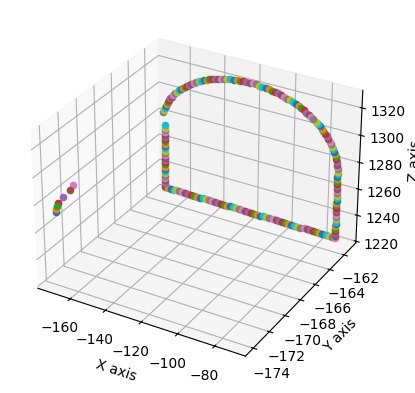

Matrix([
[-171.407276416178, -171.404168425264, -171.334247059794, -171.192056833098, -170.923126277166, -170.571326267422, -170.210810137891, -169.628660278051, -169.186437287181, -168.682579094352, -168.117735446986, -167.492634705725, -166.808083362942, -166.064964488572, -165.264236832208, -164.406933735816, -163.494161298195, -162.527097054648, -161.506988454755, -160.435151115084, -159.312966424893, -158.141880172371, -156.923400064982, -155.659093707872, -154.350586206176, -152.999557893835, -151.607741939969, -150.176922234362, -148.708930919396, -147.205646090604, -145.668989633252, -144.100924918084, -142.503454545998, -140.878618056972, -139.228489128231, -137.555173668639, -135.860806469788, -134.147548977574, -132.417586309976, -130.673124323443, -128.916386756637, -127.149612635945, -125.375052988723, -123.594968137561, -121.811624850533, -120.027293635578,  -118.24424548798, -116.464749677308, -114.691070282177, -112.925463730354,  -111.17017594788, -109.427439730626, -1

In [16]:
#PLOTTING END EFFECTOR POSITION
end_effector_xyz = sp.zeros(3,arraysize)

for c in range(0,arraysize):
    Asubs = subs_function(A_final,THETA[:,c])
    end_effector_xyz[0,c] = Asubs[0,3]
    end_effector_xyz[1,c] = Asubs[1,3] #compensating for pencil length
    end_effector_xyz[2,c] = Asubs[2,3]



#PLOT END EFFECTOR PATH
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for i in range(0,arraysize):
    
    ax.scatter([end_effector_xyz[0,i]], [end_effector_xyz[1,i]], [end_effector_xyz[2,i]])


# Set labels
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')


# Show plot
plt.show()

end_effector_xyz


In [17]:
ee_A_final

Matrix([
[-171.407276416178],
[-174.007385005166],
[ 1273.32313359653],
[                0],
[                0],
[                0]])